<a href="https://colab.research.google.com/github/Giovanni-Zara/grapevine-berries-anomaly-detection-with-SAM-using-zero-shot-learning/blob/main/grapevine_berries_anomaly_detection_using_GSAM_zero_shot_learning_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

#PROJECT STRUCTURE


Dataset Preparation:

* Dataset Class: Well-define my dataset to load and preprocess the images.
* Dataset Splitting: Spliting my dataset into training, validation, and test sets. In particular I will initially split my dataset just in validation and training set, as I'm using a pretrained model for the first step.
Eventually, I will split again the segmented masks

Model Initialization:

* Load Grounded SAM:

* Initialize the Grounded SAM model for segmentation.

Segmentation:

* Segment Images: I will use Grounded SAM to segment images into different regions in two methods:
  * good samples -> from good samples i'm segmenting quite all i can extract, basically i want to reduce noise and remove background.
  * bad samples -> from bad samples i'm segmenting just the areas that the algorithm identificates as anomalies.
* Then i want to normalize this segmented masks to computationally simplify the processing of anomaly detection and classification.

Feature Extraction:

* Extract Features: I want to extract meaningful features from the segmented regions (e.g., histograms, texture features, shape features...).
In particular I want to extract the same features from the good and the bad masks.

Anomaly Detection:

* Train a Classifier: I will train a classifier (a simple neural network) using the features I extracted from good grapes.
* Anomaly Detection: Use the classifier to detect anomalies in the test set.

Evaluation:

  * Metrics:

    * Evaluate the performance using precision, recall, F1-score, accuracy and other relevant metrics.



#Dataset preparation

In [ ]:
import random
import numpy as np

#classe per la creazione di dataset
import os
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import random
from sklearn.preprocessing import StandardScaler
import pandas as pd



class CanopiesDataset(Dataset):
    def __init__(self, root_dir, classe="every", scale="every"):
        self.root_dir = root_dir
        self.class_names = sorted(os.listdir(root_dir), reverse=True)
        self.image_paths = []

        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            scale_dirs = os.listdir(class_dir)
            for scale_dir in scale_dirs:
                scale_path = os.path.join(class_dir, scale_dir)
                image_names = os.listdir(scale_path)
                for image_name in image_names:
                    if image_name.endswith(".jpg"):
                        if "hdr" not in image_name.lower():
                            if (classe == "every" or classe == class_name):
                                if (scale == "every" or scale == scale_dir):
                                    image_path = os.path.join(scale_path, image_name)
                                    self.image_paths.append((image_path, self.class_names.index(class_name)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        return image_path, label

    def __open_image(self, idx):
        image = Image.open(self.image_paths[idx][0]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image



def check_index(index, dataset):
  dataset_size = len(dataset)
  if(index > dataset_size):
    raise IndexError("Index out of bounds")
  return 1


def distribution(dataset, titolo):
    labels = np.array(list(zip(*dataset))[1])
    count_0 = np.sum(labels == 0)
    count_1 = len(labels) - count_0
    labels_count = np.array([count_0, count_1])
    class_names = ["good", "bad"]

    plt.figure(figsize=(8, 4))
    plt.title('Data distribution of '+ titolo)
    plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
    plt.show()
    print(labels_count)

'''
from sklearn.preprocessing import StandardScaler
import pandas as pd

#normalizzazione standard
def norm_dataset(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

'''
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the same size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])'''


'\ntransform = transforms.Compose([\n    transforms.Resize((224, 224)),  # Resize the images to the same size\n    transforms.ToTensor(),  # Convert the images to PyTorch tensors\n    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images\n])'

In [ ]:
import os
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive',force_remount=True)
DATA_DIR = os.path.join("drive", "MyDrive", "Canopies-data")

Mounted at /content/drive


In [ ]:
# Create an instance of the CanopiesDataset
root_dir="/content/drive/MyDrive/first_dataset"
dataset_raw = CanopiesDataset(root_dir, classe="every", scale="every")


# Check the number of images in the dataset
print(f"Total number of images: {len(dataset_raw)}")

Total number of images: 1282


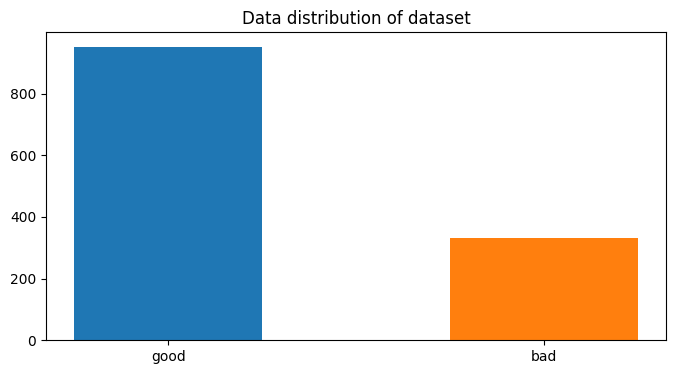

[951 331]


In [ ]:
distribution(dataset_raw,"dataset")

##dataset balance considerations

As i can see from the above graph, this dataset is not perfectly balanced.
To evaluate the imbalance ratio of a dataset i analyze this formula:

$\text{Imbalance ratio} = \frac{\text{Number of samples in minority class}}{\text{Number of samples in majority class}} = \frac{350}{950} \approx 0.3684$

For problems such as mine, it's generally accepted to have an imbalance ratio about 1:3.
So for each element in the minority class(bad samples) i can have 3 elements in the majority class(good samples)

Therefore i can considerate my dataset *acceptable* with no downsampling operations to implement

##train-validation-test set splitting function

In [ ]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to split.
        train_ratio (float): The proportion of the dataset to include in the training set.
        val_ratio (float): The proportion of the dataset to include in the validation set.
        test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
        tuple: A tuple containing the training, validation, and test subsets.
    """
    epsilon = 1e-10  # Small epsilon to handle floating-point precision issues
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < epsilon, "Ratios must sum to 1"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset


##dataloaders function

In [ ]:
def create_dataloaders(train_subset, val_subset, test_subset, batch_size=32):
    """
    Creates DataLoader objects for training, validation, and test sets.

    Args:
        train_subset (torch.utils.data.Dataset): The training subset.
        val_subset (torch.utils.data.Dataset): The validation subset.
        test_subset (torch.utils.data.Dataset): The test subset.
        batch_size (int): The number of samples per batch to load.

    Returns:
        tuple: A tuple containing DataLoader objects for the training, validation, and test sets.
    """
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
train_subset, val_subset, test_subset = split_dataset(dataset_raw, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

# Create DataLoader objects
train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_subset, test_subset, batch_size=32)

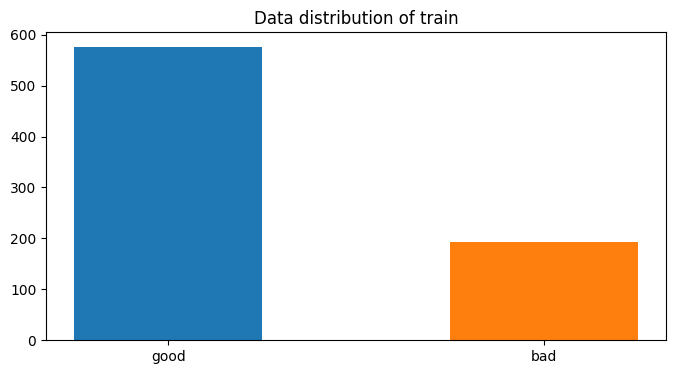

[576 193]


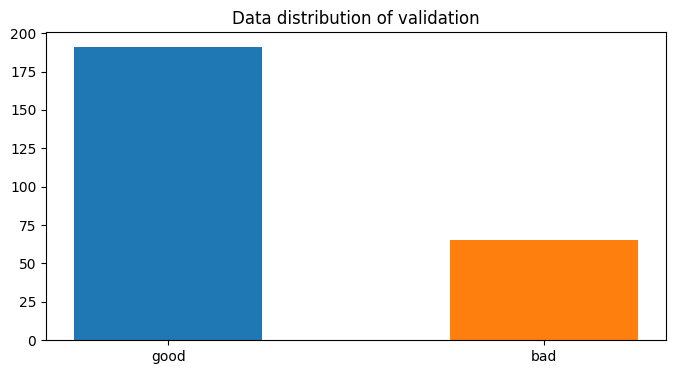

[191  65]


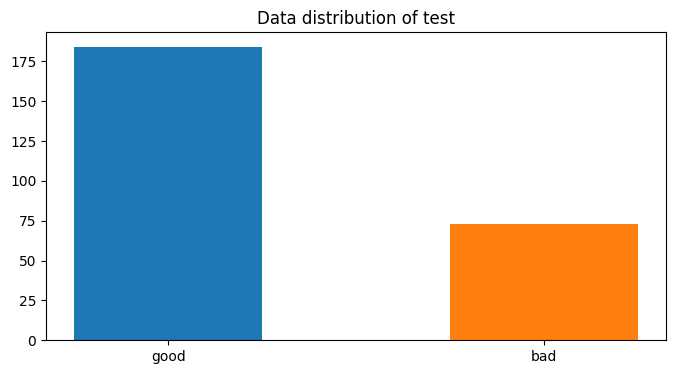

[184  73]


In [ ]:
distribution(train_subset, "train")
distribution(val_subset, "validation")
distribution(test_subset, "test")

#Setting up model


In [ ]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

##Dedicated dataclass for ground dino results

In [ ]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))


##Plot utils

In [ ]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:  #Drawing bounding boxes around detected objects. Optionally overlaying segmentation masks (if available) over the detected objects.
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box on the images when plotting
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it      seen on repo
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(        #actual plotting detections
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()


##Code for plots

In [ ]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors        #for plot utilities
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(     #interactive plot to change masks, it visualizes the image info hovering with mouse
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()



##other utils

In [ ]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

##Grounded Segment Anything (SAM)
I'll use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
Then, prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

In [ ]:
def detect(     #####whith this I search for bounding boxes that resembles text
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny" #dino checkpoint
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]    #text prompts list

    results = object_detector(image,  candidate_labels=labels, threshold=threshold) #box detection
    results = [DetectionResult.from_dict(result) for result in results] #results data

    return results

def segment(      ###now i can use SAM with the bounding boxes as prompt to segment
    image: Image.Image,
    detection_results: List[Dict[str, Any]],    #big results data
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"      ##SAM checkpoint-> base is the huge one/// maybe i could have used also the large. the performances are better like this

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)   #segment model
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)

    #if

    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs) ## i unpack the dictionaries, inputs is dict. With ** i unpack the dict to pass the keys to the function segmentator
    masks = processor.post_process_masks(     ##post process of masks, GSAM repo
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):  #zip iterates tuples
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(    #now I can merge the two function of detect and segment
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections


#Segmentation
Now I need to segment my masks from the good and the bad dataset with two different approaches.

I will split the good dataset in train, val and test in order to segment train, val and test masks.<br>
While the bad dataset will be splitted just in val and test, as i will not have to train the classificator also on bad features

##Bad segmentation
For the bad dataset i'm using the following logic:
I need to extract from this dataset what the algorithm detects to be a BAD patch, so a sick mask.
To do so I want to validate the model with different combination of accuracy thresholds and different combinations of text prompts.
I will then choose the combo that returns the bigger number of masks with the better accuracy.
So a mean of the masks weighted on their accuracy.

In [ ]:
import random
from itertools import combinations

# Initial list of prompts with additional synonyms
prompts = [
    "rotten.", "sick.", "moldy.", "black.", "putrid.", "decomposed.",
    "diseased.", "infected.", "decayed.", "blighted.", "tainted.", "spoiled.", "wilted."
]

# Generate combinations of exactly 3 prompts
all_combinations = list(combinations(prompts, 6))

# Shuffle the combinations list to ensure randomness
random.shuffle(all_combinations)

# Ensure unique combinations to maximize diversity
unique_combinations = []
used_prompts = set()

for combo in all_combinations:
    combo_set = frozenset(combo)
    if combo_set not in used_prompts:
        unique_combinations.append(list(combo))
        used_prompts.add(combo_set)
    if len(unique_combinations) == 5:
        break

# Shuffle the prompts within each combination to add more randomness
for combo in unique_combinations:
    random.shuffle(combo)

# Print all combinations to verify
for idx, combo in enumerate(unique_combinations):
    print(f"Combination {idx + 1}: {combo}")

# Print the total number of combinations
print(f"Total number of combinations: {len(unique_combinations)}")


Combination 1: ['putrid.', 'wilted.', 'moldy.', 'sick.', 'black.', 'spoiled.']
Combination 2: ['wilted.', 'tainted.', 'rotten.', 'moldy.', 'infected.', 'blighted.']
Combination 3: ['putrid.', 'moldy.', 'wilted.', 'tainted.', 'diseased.', 'blighted.']
Combination 4: ['diseased.', 'infected.', 'sick.', 'black.', 'decomposed.', 'tainted.']
Combination 5: ['tainted.', 'putrid.', 'diseased.', 'moldy.', 'black.', 'wilted.']
Total number of combinations: 5


In [ ]:
dataset_BAD = CanopiesDataset(root_dir, classe="bad", scale="every")
dataset_GOOD = CanopiesDataset(root_dir, classe="good", scale="every")

In [ ]:
image_url = "/content/drive/MyDrive/first_dataset/bad/scale_2/IMG_20210924_171510186_HDR_00.jpg"
labels = ["sick .", "anomalous.", "diseased.","moldy.","black."]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

###an example of what i'm doing

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[DetectionResult(score=0.516847550868988, label='anomalous.', box=BoundingBox(xmin=271, ymin=194, xmax=491, ymax=570), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.42404088377952576, label='moldy.', box=BoundingBox(xmin=60, ymin=49, xmax=307, ymax=575), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.3299435079097748, label='sick .', box=BoundingBox(xmin=0, ymin=0, xmax=600, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
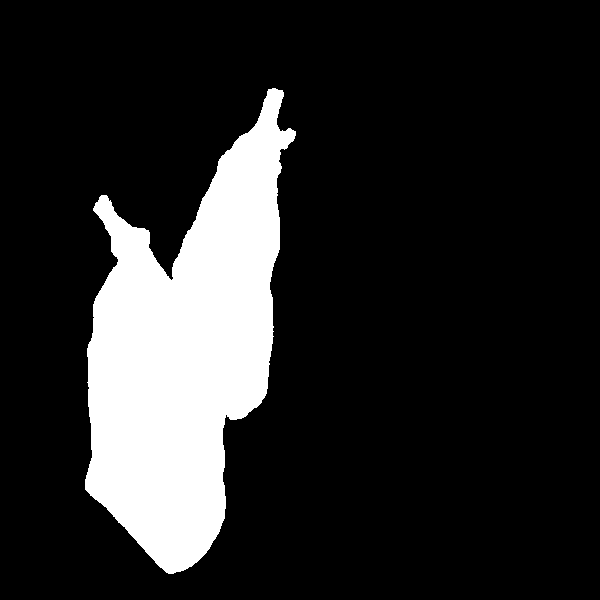

In [ ]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)
print(detections)
detections[1].mask

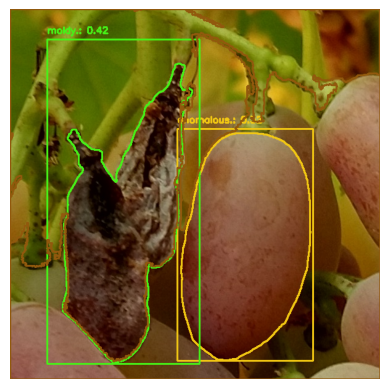

In [ ]:
plot_detections(image_array, detections, "uva")

In [ ]:
plot_detections_plotly(image_array, detections)

###validations of prompts
In the following cells i validate the best prompts on the first 100 bad images(for computational problems), so the prompts that can extract more patches from my bad dataset.
I iterate on a combination of shuffled useful prompts and i check the maximum number of segmented masks that these prompts produce.

If I happen to find the same number of masks for different prompts combination then I compare the accuracy score with which the masks are produced, choosing the prompts with the better one.

In [ ]:
'''dataset_BAD_size = len(dataset_BAD)

indices = list(range(dataset_BAD_size))
random.shuffle(indices)
val_ratio = 0.3
val_end = int(val_ratio * dataset_BAD_size)
val_indices = indices[:val_end]

dataset_BAD_val_subset = Subset(dataset_BAD, val_indices)
'''

In [ ]:
dataset_BAD_train, dataset_BAD_val, dataset_BAD_test = split_dataset(dataset_BAD, 0.0, 0.3, 0.7)  ##No train! model is pre trained

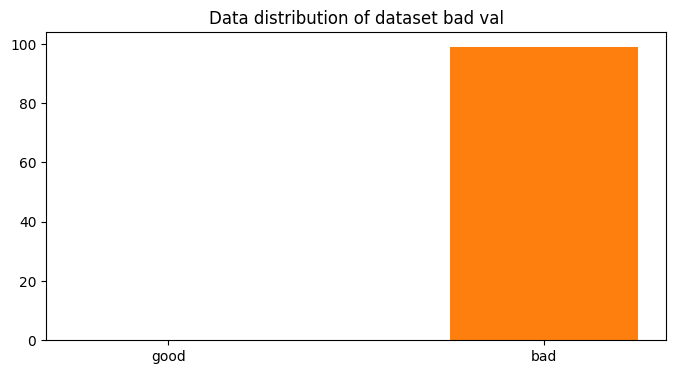

[ 0 99]


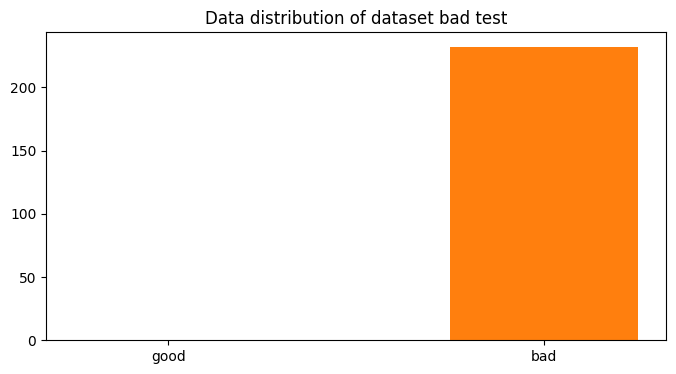

[  0 232]


In [ ]:
#distribution(dataset_BAD_train, "dataset bad train")
distribution(dataset_BAD_val, "dataset bad val")
distribution(dataset_BAD_test, "dataset bad test")

In [ ]:
max_masks = -1
best_prompts = None
best_detections = None
best_scores_sum = 0
cont = 0
temp = 0
for prompts in unique_combinations:
    print("combo n.", cont)
    print("best prompts so far:",best_prompts)
    num = 0
    scores_sum = 0

    for i in range(len(dataset_BAD_val)):

        try:
            image_array, detections = grounded_segmentation(
                image=dataset_BAD.__getitem__(i)[0],
                labels=prompts,
                threshold=threshold,
                polygon_refinement=True,
                detector_id=detector_id,
                segmenter_id=segmenter_id
            )

            num += len(detections)  # Sum of all masks found with this prompt
            scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

            print("\timmagine n.", i, "/100")

        except IndexError:
            print(f"\tIndexError at image index {i}. Skipping this image.")
            continue

    # Change prompt
    if num > max_masks:
        max_masks = num
        best_prompts = prompts
        best_scores_sum = scores_sum
        # best_detections = detections

    elif num == max_masks:
        if scores_sum > best_scores_sum:
            best_prompts = prompts
            best_scores_sum = scores_sum
            # best_detections = detections

    cont += 1

print("so the best prompts are: ",best_prompts)

combo n. 0
best prompts so far: None
	immagine n. 0 /100
	immagine n. 1 /100
	immagine n. 2 /100
	immagine n. 3 /100
	immagine n. 4 /100
	immagine n. 5 /100
	immagine n. 6 /100
	immagine n. 7 /100
	immagine n. 8 /100
	immagine n. 9 /100
	immagine n. 10 /100
	immagine n. 11 /100
	immagine n. 12 /100
	immagine n. 13 /100
	immagine n. 14 /100
	immagine n. 15 /100
	immagine n. 16 /100
	immagine n. 17 /100
	immagine n. 18 /100
	immagine n. 19 /100
	immagine n. 20 /100
	immagine n. 21 /100
	immagine n. 22 /100
	immagine n. 23 /100
	immagine n. 24 /100
	immagine n. 25 /100
	immagine n. 26 /100
	immagine n. 27 /100
	immagine n. 28 /100
	immagine n. 29 /100
	immagine n. 30 /100
	immagine n. 31 /100
	immagine n. 32 /100
	immagine n. 33 /100
	immagine n. 34 /100
	immagine n. 35 /100
	immagine n. 36 /100
	immagine n. 37 /100
	immagine n. 38 /100
	immagine n. 39 /100
	immagine n. 40 /100
	immagine n. 41 /100
	immagine n. 42 /100
	immagine n. 43 /100
	immagine n. 44 /100
	immagine n. 45 /100
	immagi

In [ ]:
best_prompts = ['blighted.', 'sick.', 'tainted.', 'putrid.', 'black.', 'rotten.']
print(best_prompts)

['blighted.', 'sick.', 'tainted.', 'putrid.', 'black.', 'rotten.']


###segment with best hyperparameters
Now that I have chosen the better prompts among my combination, i can segment all the bad dataset to obtain the mask from which i have to extract features

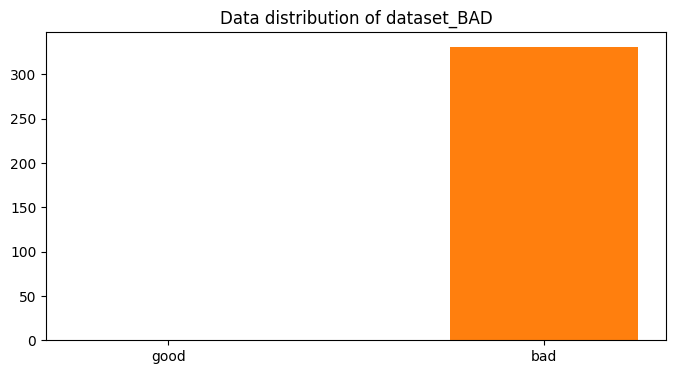

[  0 331]


In [ ]:
distribution(dataset_BAD, "dataset_BAD")

In [ ]:
cont = 0
bad_masks=[]
bad_boxes=[]
detections_list=[]
for i in range(len(dataset_BAD)):
    try:
        image_array, detections = grounded_segmentation(
            image=dataset_BAD.__getitem__(i)[0],
            labels=best_prompts,
            threshold=threshold,
            polygon_refinement=True,
            detector_id=detector_id,
            segmenter_id=segmenter_id
        )
        detections_list.append(detections)
        for item in detections:
          bad_masks.append(item.mask)   ##appending all the masks in a list
          bad_boxes.append(item.box)

        #num += len(detections)  # Sum of all masks found with this prompt
        #scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

        print("\timmagine n.", i, "/",len(dataset_BAD))


    except IndexError:        ##if it doesn't find any masks for an image, so run does not block
        print(f"\tIndexError at image index {i}. Skipping this image.")
        continue


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


	immagine n. 0 / 331
	immagine n. 1 / 331
	immagine n. 2 / 331
	immagine n. 3 / 331
	immagine n. 4 / 331
	immagine n. 5 / 331
	immagine n. 6 / 331
	immagine n. 7 / 331
	immagine n. 8 / 331
	immagine n. 9 / 331
	immagine n. 10 / 331
	immagine n. 11 / 331
	immagine n. 12 / 331
	immagine n. 13 / 331
	immagine n. 14 / 331
	immagine n. 15 / 331
	immagine n. 16 / 331
	immagine n. 17 / 331
	immagine n. 18 / 331
	immagine n. 19 / 331
	immagine n. 20 / 331
	immagine n. 21 / 331
	immagine n. 22 / 331
	immagine n. 23 / 331
	immagine n. 24 / 331
	immagine n. 25 / 331
	immagine n. 26 / 331
	immagine n. 27 / 331
	immagine n. 28 / 331
	immagine n. 29 / 331
	immagine n. 30 / 331
	immagine n. 31 / 331
	immagine n. 32 / 331
	immagine n. 33 / 331
	immagine n. 34 / 331
	immagine n. 35 / 331
	immagine n. 36 / 331
	immagine n. 37 / 331
	immagine n. 38 / 331
	immagine n. 39 / 331
	immagine n. 40 / 331
	immagine n. 41 / 331
	immagine n. 42 / 331
	immagine n. 43 / 331
	immagine n. 44 / 331
	immagine n. 45 / 33

In [ ]:
print(detections_list)


[[DetectionResult(score=0.4787747263908386, label='sick.', box=BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), mask=array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.3758176863193512, label='black.', box=BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), mask=array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.31931644678115845, label='rotten.', box=BoundingBox(xmin=229, ymin=66, xmax=406, ymax=204), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]

In [ ]:
print(bad_masks)


[array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  

In [ ]:
print(bad_boxes)

[BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=229, ymin=66, xmax=406, ymax=204), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=107, ymin=106, xmax=347, ymax=412), BoundingBox(xmin=107, ymin=105, xmax=347, ymax=412), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=106, ymin=106, xmax=347, ymax=413), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=106, ymin=103, xmax=348, ymax=412), BoundingBox(xmin=190, ymin=0, xmax=337, ymax=197), BoundingBox(xmin=74, ymin=0, xmax=242, ymax=121), BoundingBox(xmin=14, ymin=0, xmax=422, ymax=449), BoundingBox(xmin=14, ymin=0, xmax=421, ymax=449), BoundingBox(xmin=63, ymin=112, xmax=242, ymax=416), BoundingBox(xmin=20, ymin=0, xmax=352, ym

###normalizing masks

In [ ]:
desired_size = (244, 244)
resized_arrays = [cv2.resize(arr, desired_size) for arr in bad_masks]
mean_value = np.mean(np.stack(resized_arrays))
std_value = np.std(np.stack(resized_arrays))

# Step 2: Normalize each array
n_bad_masks = [(arr - mean_value) / std_value for arr in resized_arrays]

In [ ]:
import numpy as np
import cv2

def resize_and_normalize_masks(image_list, desired_size=(244, 244)):
    """
    Resizes and normalizes a list of images.

    Parameters:
    - image_list: list of numpy arrays representing the images
    - desired_size: tuple indicating the desired size for resizing (default is (244, 244))

    Returns:
    - n_bad_masks: list of resized and normalized images
    """
    # Step 1: Resize each array
    resized_arrays = [cv2.resize(arr, desired_size) for arr in image_list]

    # Compute mean and standard deviation
    mean_value = np.mean(np.stack(resized_arrays))
    std_value = np.std(np.stack(resized_arrays))

    # Step 2: Normalize each array
    n_bad_masks = [(arr - mean_value) / std_value for arr in resized_arrays]

    return n_bad_masks

# Example usage:
# resized_and_normalized_images = resize_and_normalize_images(bad_masks)


In [ ]:
n_mask_bad = resize_and_normalize_masks(bad_masks, desired_size=(244, 244))

KeyboardInterrupt: 

##Good segmentation
For the good dataset I aim to extract whatever i can, removing the noise and the background.
Then I'll normalize these masks as well and

###an example of what i'm doing

In [ ]:
image_url = "/content/drive/MyDrive/first_dataset/good/scale_2/IMG_20210924_160155838_0_00.jpg"
labels = ["grape berry.", "green grape.", "red grape.","grapes.","grape.", "good grape"]
threshold = 0.4

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

[DetectionResult(score=0.8658604025840759, label='grape berry.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.8535763025283813, label='grapes.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=599), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.7698561549186707, label='green grape.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [25

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
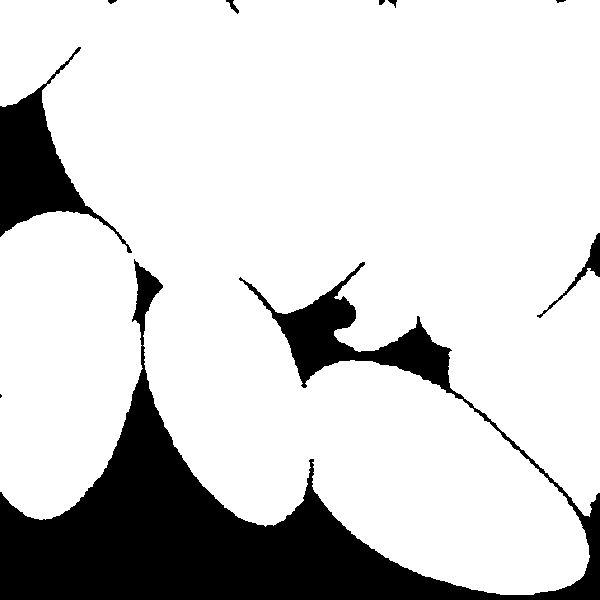

In [ ]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)
print(detections)
detections[1].mask

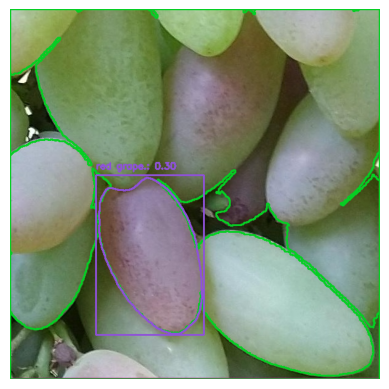

In [ ]:
plot_detections(image_array, detections, "uva")

In [ ]:
plot_detections_plotly(image_array, detections)

###Actual segmentation
Since i've decided to try to segment basically all the model can on the good dataset, i have no need to validate.<br>
Based on some tests i've done and on the model's paper, the performances of the model "easier" prompts are generally way better and similar in accuracy
Hence, i'm iterating on a combination of useful prompts to segment my good masks

In [ ]:
max_masks = -1
good_masks=[]
good_boxes=[]
detections_list_good=[]
labels = ["grape berry.", "green grape.", "red grape.","grapes.","grape.", "good grape"]
for i in range(len(dataset_GOOD)):
    try:
        image_array, detections = grounded_segmentation(
            image=dataset_GOOD.__getitem__(i)[0],
            labels=labels,
            threshold=threshold,
            polygon_refinement=True,
            detector_id=detector_id,
            segmenter_id=segmenter_id
        )
        detections_list_good.append(detections)
        for item in detections:
          good_masks.append(item.mask)   ##appending all the masks in a list
          good_boxes.append(item.box)


        #num += len(detections)  # Sum of all masks found with this prompt
        #scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

        print("\timmagine n.", i, "/", len(dataset_GOOD))


    except IndexError:        ##if it doesn't find any masks for an image
        print(f"\tIndexError at image index {i}. Skipping this image.")
        continue


	immagine n. 0 / 951
	immagine n. 1 / 951
	IndexError at image index 2. Skipping this image.
	IndexError at image index 3. Skipping this image.
	immagine n. 4 / 951
	immagine n. 5 / 951
	immagine n. 6 / 951
	immagine n. 7 / 951
	immagine n. 8 / 951
	immagine n. 9 / 951
	immagine n. 10 / 951
	immagine n. 11 / 951
	IndexError at image index 12. Skipping this image.
	immagine n. 13 / 951
	immagine n. 14 / 951
	IndexError at image index 15. Skipping this image.
	immagine n. 16 / 951
	immagine n. 17 / 951
	immagine n. 18 / 951
	IndexError at image index 19. Skipping this image.
	immagine n. 20 / 951
	immagine n. 21 / 951
	immagine n. 22 / 951
	immagine n. 23 / 951
	immagine n. 24 / 951
	immagine n. 25 / 951
	immagine n. 26 / 951
	immagine n. 27 / 951
	immagine n. 28 / 951
	immagine n. 29 / 951
	immagine n. 30 / 951
	immagine n. 31 / 951
	immagine n. 32 / 951
	immagine n. 33 / 951
	immagine n. 34 / 951
	immagine n. 35 / 951
	immagine n. 36 / 951
	immagine n. 37 / 951
	immagine n. 38 / 951
	i

###normalizing good masks

In [ ]:
n_good_masks = resize_and_normalize_masks(good_masks, desired_size=(244, 244))

In [ ]:
print(good_boxes)

[BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=96, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=128, ymax=254), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=126, ymax=254), BoundingBox(xmin=86, ymin=0, xmax=299, ymax=105), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), Bounding

#Feature extractions
Now i have to extract features from the good and the bad masks that I've segmented.

I could manually extract features like histograms of pixel intensities, shape features, edge detections, statistical features....
But it's more efficient to use a Convolutional Neural Network trained for feature extraction.<br>
CNNs automatically learn relevant features from the data, eliminating the need for manual feature extraction and selection.
They have a hierarchical learning approach to features, starting from simple edges till more comples structures.<br>
A CNN can generalize better to unseen data, provided they are trained on large and diverse datasets. They can capture intricate patterns that traditional features might miss.

I am going to use a pretrained CNN model, ResNet, following these steps:
* load the CNN and load the model;
* remove the last layers (classification layers) to get feature vector from the convolutional layers;
* transform the image and normalize it with the mean and std used in the model (resnet ones);
* extracting features and putting them into np arrays

For this task I'm gonna use VGG16 (Visual Geometry Group 16), a convolutional neural network architecture that was proposed by the Visual Geometry Group at the University of Oxford. It is part of the VGG family of models, which were developed for image classification and object detection task.


###setting up vgg16

In [ ]:
!pip install tensorflow

In [ ]:
# Load VGG16 model with pre-trained weights and exclude the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# Define the model to output features from the last convolutional block
#model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

###good features extraction

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import torch


# Step 1: Create 3-channel images
list_of_rgb_arrays = [np.stack((img, img, img), axis=-1) for img in n_good_masks]

# Step 2: Convert to PyTorch tensors
list_of_tensors = [torch.tensor(arr) for arr in list_of_rgb_arrays]

# Step 3: Organize into a single tensor
final_tensor = torch.stack(list_of_tensors)

# Print shapes for verification
#print(f"Shape of final tensor: {final_tensor.shape}")
final_tensor_np = final_tensor.numpy()##i convert to numpy cause tensor does not support a negative strip operation that the model does!!

images = preprocess_input(final_tensor_np)  # Preprocess input for VGG16

#model = VGG16(weights='imagenet', include_top=False)

# Extract features
good_masks_features = model.predict(images)

# The shape of features will be (number of images, 7, 7, 512) for VGG16 with 'block5_pool' layer
print(good_masks_features.shape)
#EUREKA, IT WORKS!

151/151 [==============================] - 5s 31ms/step
(4816, 7, 7, 512)


In [ ]:
print(good_masks_features)

[[[[ 0.          0.          0.         ...  0.          1.2199398
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.    

####saving features in google drive
I'm saving features tensor in my drive.
This to avoid to run again all the hours of code next time runtime disconnects

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Step 2: Save the features
import numpy as np
np.save('/content/drive/MyDrive/good_masks_features_new.npy', good_masks_features)




Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Later, to load the features again
import numpy as np
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the features
good_masks_features = np.load('/content/drive/MyDrive/good_masks_features_new.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(good_masks_features)

[[[[ 0.          0.          0.         ...  0.          1.2199398
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.    

In [ ]:
print(good_masks_features.shape)
print(good_masks_features.dtype)
print(type(good_masks_features))

(4816, 7, 7, 512)
float32
<class 'numpy.ndarray'>


###bad features extraction

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import torch


# Step 1: Create 3-channel images because my masks are greyscaled so I need to "fake" the rgb stacking 3 identical layer
list_of_rgb_arrays = [np.stack((img, img, img), axis=-1) for img in n_bad_masks]

# Step 2: Convert to PyTorch tensors
list_of_tensors = [torch.tensor(arr) for arr in list_of_rgb_arrays]

# Step 3: Organize into a single big tensor
final_tensor = torch.stack(list_of_tensors)

# Print shapes for verification
#print(f"Shape of final tensor: {final_tensor.shape}")
final_tensor_np = final_tensor.numpy()##i convert to numpy cause tensor does not support a negative strip operation that the model does!!

images = preprocess_input(final_tensor_np)  # Preprocess input for VGG16

model = VGG16(weights='imagenet', include_top=False)

# Extract features
bad_masks_features = model.predict(images)

# The shape of features will be (number of images, 7, 7, 512) for VGG16 with 'block5_pool' layer
print(bad_masks_features.shape)
#EUREKA, IT WORKS!

92/92 [==============================] - 6s 38ms/step
(2938, 7, 7, 512)


In [ ]:
print(bad_masks_features)

[[[[ 0.          0.          0.         ...  0.          0.93761516
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          3.4900553
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...

####saving them in drive

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Step 2: Save the features
import numpy as np
np.save('/content/drive/MyDrive/bad_masks_features.npy', bad_masks_features)



Mounted at /content/drive


NameError: name 'bad_masks_features' is not defined

In [ ]:
# Later, to load the features again

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the features
bad_masks_features = np.load('/content/drive/MyDrive/bad_masks_features.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(bad_masks_features.shape)
print(bad_masks_features.dtype)
print(type(bad_masks_features))

(2938, 7, 7, 512)
float32
<class 'numpy.ndarray'>


In [ ]:
print(bad_masks_features)

[[[[ 0.          0.          0.         ...  0.          0.93761516
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          3.4900553
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...

#resizing features tensors
I'll produce also a downsampled version of good features tensor, to balance my classificstion.<br>
In the following section I'll analyze some visual plots with both the downsampled and normal tensor

In [ ]:
import numpy as np


# Randomly select 2938 indices from the large tensor
indices = np.random.choice(good_masks_features.shape[0], size=bad_masks_features.shape[0], replace=False)

# Create the downsampled tensor
good_features_downsampled = good_masks_features[indices]

print("Shape of downsampled large tensor:", good_features_downsampled.shape)


Shape of downsampled large tensor: (2938, 7, 7, 512)


#Visual analysis of the feature from some plots

In [ ]:
!pip install matplotlib seaborn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##heatmap
Given the shape of my feature tensors, i have to reduce the dimensionality to show the plot.<br>
I will average and select a subset of channels for the visualization

I'm averaging the features across the 512 channels to create a 2D representation of the 7x7 feature maps.

In [ ]:
# Function to average feature maps across channels
def average_feature_maps(feature_tensor):
    return np.mean(feature_tensor, axis=-1)

# Apply the function to your feature tensors
good_masks_avg = average_feature_maps(good_masks_features)
bad_masks_avg = average_feature_maps(bad_masks_features)


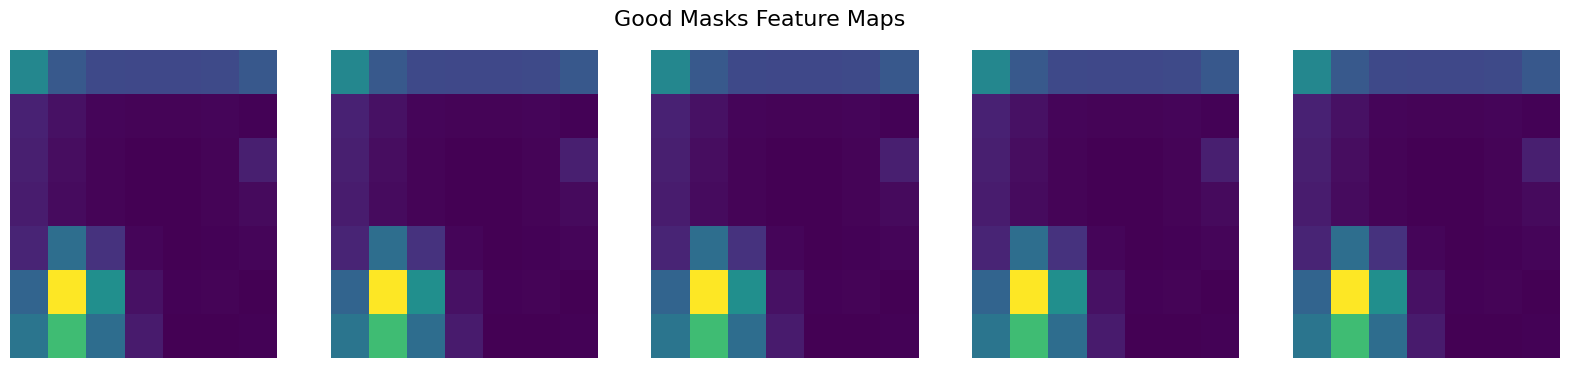

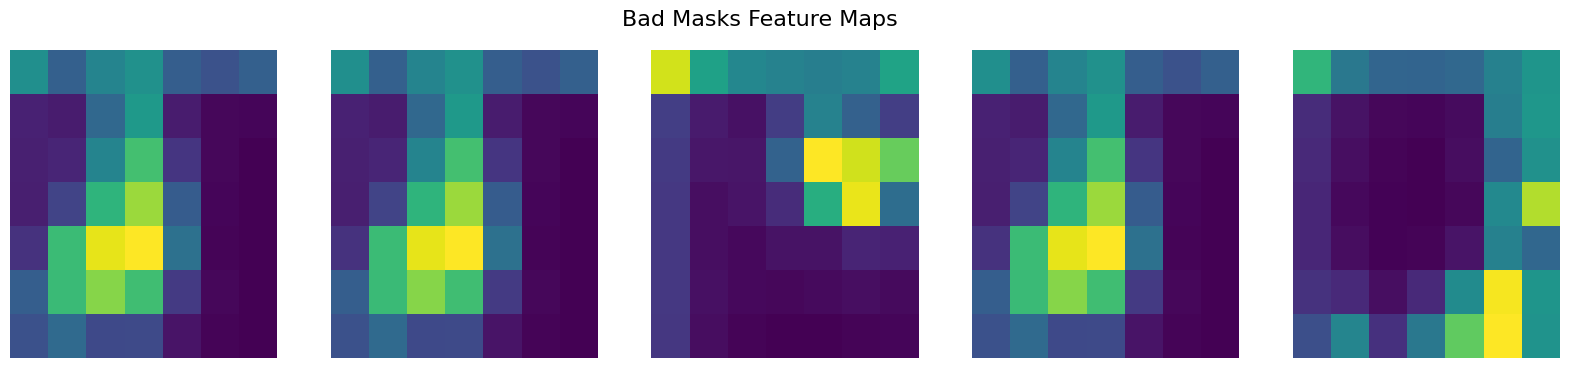

In [ ]:
def plot_heatmaps(feature_maps, title, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)
    for i in range(num_examples):
        sns.heatmap(feature_maps[i], ax=axes[i], cmap='viridis', cbar=False)
        axes[i].axis('off')
    plt.show()

# Plot heatmaps for a few examples from good masks and bad masks
plot_heatmaps(good_masks_avg, 'Good Masks Feature Maps', num_examples=5)
plot_heatmaps(bad_masks_avg, 'Bad Masks Feature Maps', num_examples=5)


The heat maps of the bas masks have some similarities in their structure.<br>
Most of them show a central region with higher intensity (yellow/green) surrounded by lower intensity areas (purple/blue). This suggests that the CNN has identified a common feature or pattern in the bad masks, often centered within the region.

On the good masks instead, the maps are more consistent.<nr>
The activations are similarly located and show a stable pattern, indicating the model recognizes a reliable and repeatable feature in good masks.(this should be good for my next classification)

In summary, the comparison highlights that the model has a clearer, more consistent understanding of good masks, while it shows more uncertainty and variability when dealing with bad masks.<br>
I should take this into account when evaluating my classification

##principal component analysis (PCA)

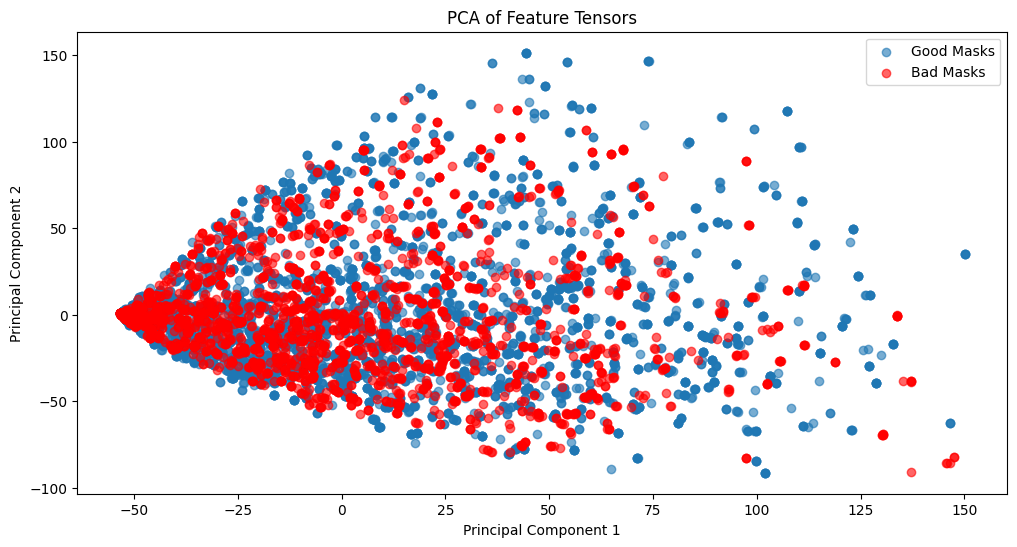

In [ ]:
from sklearn.decomposition import PCA

# Combine the data for PCA
combined_features = np.concatenate([good_masks_features, bad_masks_features], axis=0)
combined_features_flat = combined_features.reshape((combined_features.shape[0], -1))

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_features_flat)

# Separate the results
good_pca = pca_result[:len(good_masks_features)]
bad_pca = pca_result[len(good_masks_features):]

# Plot PCA result
plt.figure(figsize=(12, 6))
plt.scatter(good_pca[:, 0], good_pca[:, 1], label='Good Masks', alpha=0.6)
plt.scatter(bad_pca[:, 0], bad_pca[:, 1], label='Bad Masks', alpha=0.6, color='red')
plt.title('PCA of Feature Tensors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


The plot shows a significant overlap between the features of good masks (blue) and bad masks (red). This indicates that the features extracted by the CNN from the masks are not distinctly separated into good and bad categories.<br>
This might be due to the not perfect performance of the detection and segmentation algorithm.<br>
Since in the bad grapes photo there were also some good grapes features, i can address this overlapping to the segmentation algorithm
Nonetheless, i can see that the data has some structure, even if it could have been better defined.


##PCA with downsized good features to balance the datas

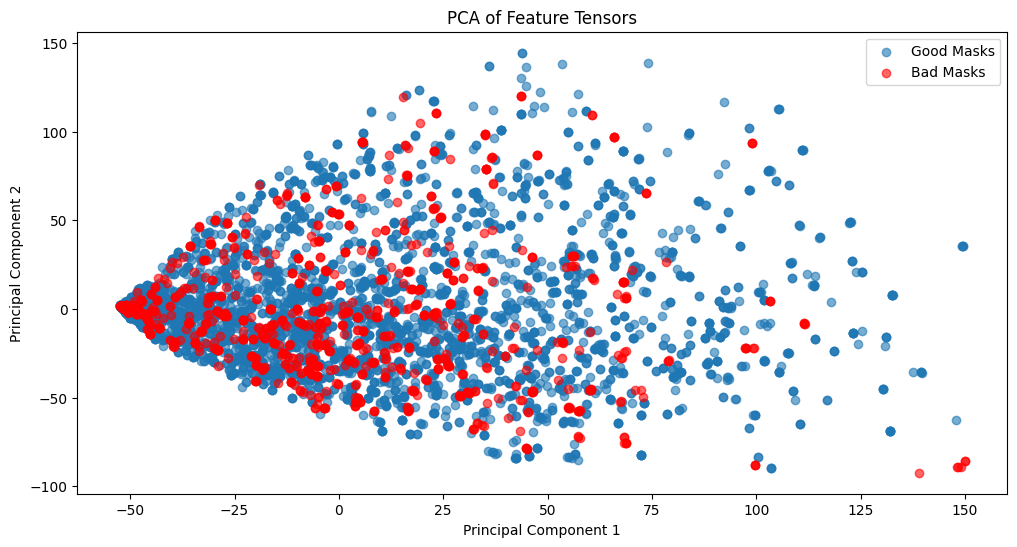

In [ ]:
from sklearn.decomposition import PCA

# Combine the data for PCA
combined_features = np.concatenate([good_features_downsampled, bad_masks_features], axis=0)
combined_features_flat = combined_features.reshape((combined_features.shape[0], -1))

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_features_flat)

# Separate the results
good_pca = pca_result[:len(good_masks_features)]
bad_pca = pca_result[len(good_masks_features):]

# Plot PCA result
plt.figure(figsize=(12, 6))
plt.scatter(good_pca[:, 0], good_pca[:, 1], label='Good Masks', alpha=0.6)
plt.scatter(bad_pca[:, 0], bad_pca[:, 1], label='Bad Masks', alpha=0.6, color='red')
plt.title('PCA of Feature Tensors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


##T-SNE Visualization
T-SNE is another dimensionality reduction technique that can be used to visualize the feature space.

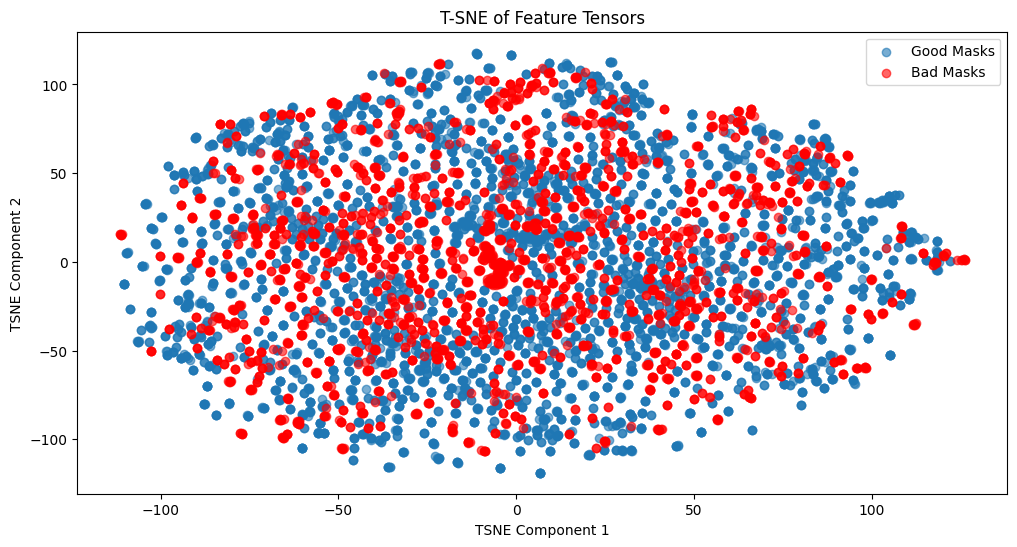

In [ ]:
from sklearn.manifold import TSNE

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_features_flat)

# Separate the results
good_tsne = tsne_result[:len(good_masks_features)]
bad_tsne = tsne_result[len(good_masks_features):]

# Plot TSNE result
plt.figure(figsize=(12, 6))
plt.scatter(good_tsne[:, 0], good_tsne[:, 1], label='Good Masks', alpha=0.6)
plt.scatter(bad_tsne[:, 0], bad_tsne[:, 1], label='Bad Masks', alpha=0.6, color='red')
plt.title('T-SNE of Feature Tensors')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()


In this graph I can appreciate more local clustering respect to the previous one.<br>
I can still see some overlapping features.

##T-SNE with downsized good features to balance the datas

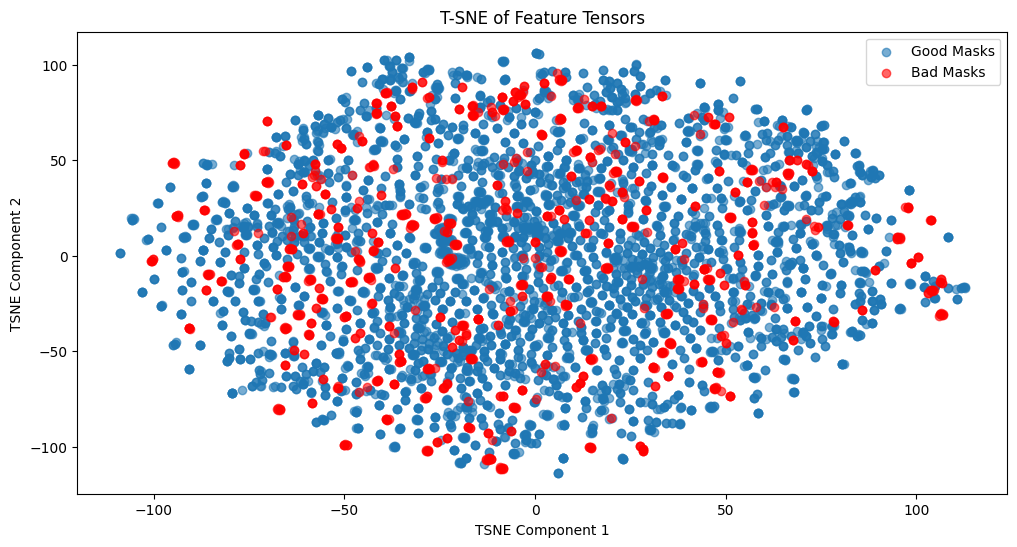

In [ ]:
from sklearn.manifold import TSNE

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(combined_features_flat)

# Separate the results
good_tsne = tsne_result[:len(good_masks_features)]
bad_tsne = tsne_result[len(good_masks_features):]

# Plot TSNE result
plt.figure(figsize=(12, 6))
plt.scatter(good_tsne[:, 0], good_tsne[:, 1], label='Good Masks', alpha=0.6)
plt.scatter(bad_tsne[:, 0], bad_tsne[:, 1], label='Bad Masks', alpha=0.6, color='red')
plt.title('T-SNE of Feature Tensors')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()


I can appreciate better clustering but still there is much overlapping.<br>The feature extraction is not perfect

In [ ]:
print(bad_masks_features.shape)
print(good_features_downsampled.shape)

(2938, 7, 7, 512)
(2938, 7, 7, 512)


##Mean Feature Map Visualization
Visualizing the mean of the feature maps across all examples can give insight into the average pattern learned by the network.

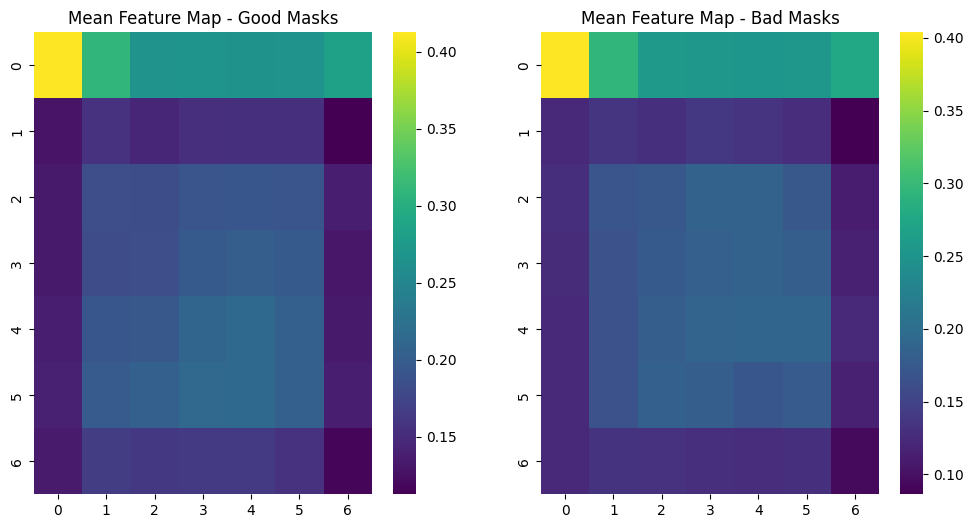

In [ ]:
# Calculate the mean feature map
mean_good_feature_map = np.mean(good_masks_avg, axis=0)
mean_bad_feature_map = np.mean(bad_masks_avg, axis=0)

# Plot the mean feature maps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(mean_good_feature_map, cmap='viridis')
plt.title('Mean Feature Map - Good Masks')

plt.subplot(1, 2, 2)
sns.heatmap(mean_bad_feature_map, cmap='viridis')
plt.title('Mean Feature Map - Bad Masks')

plt.show()


This maps confirms the evaluations of the first plots.<br>
The more focused and distinct activations in the good masks feature map indicate higher confidence and reliability in the model's feature detection for good masks.
The more spread out and uniform activations in the bad masks feature map suggest that the model is less confident and finds it harder to pinpoint specific features in bad masks.<br>
The bad masks feature map suggests that errors in masks lead to a more generalized and less precise activation pattern. This could be due to noise or inconsistencies in the bad masks that the model cannot effectively learn from.(again this might be a segmentation problem)

In summary, the comparison shows that the model has a clearer, more consistent understanding of good masks, while it struggles more with bad masks.

#Classification - Anomaly detection
Now that we have extracted all the features from good and bad masks we can start with the classification

##setting features dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

#good_masks_features = np.load('path/to/good_masks_features.npy')
#bad_masks_features = np.load('path/to/bad_masks_features.npy')

# Convert NumPy arrays to PyTorch tensors
good_masks_features = torch.tensor(good_features_downsampled, dtype=torch.float32)
bad_masks_features = torch.tensor(bad_masks_features, dtype=torch.float32)

# Create labels: 1 for good masks, 0 for bad masks
good_labels = torch.zeros(good_masks_features.size(0))   #good are 0
bad_labels = torch.ones(bad_masks_features.size(0))     #bad are 1

# Combine features and labels
features = torch.cat((good_masks_features, bad_masks_features), dim=0)
labels = torch.cat((good_labels, bad_labels), dim=0)

# Create a dataset
dataset = TensorDataset(features, labels)

# Split the dataset into train, validation, and test sets

train_dataset, val_dataset, test_dataset = split_dataset(dataset, 0.7, 0.15, 0.15)    # my function defined at the beginning

# Create dataloaders
batch_size = 32
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size)   #my function defined at the beginning
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<ipython-input-65-96acfae529cc>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bad_masks_features = torch.tensor(bad_masks_features, dtype=torch.float32)


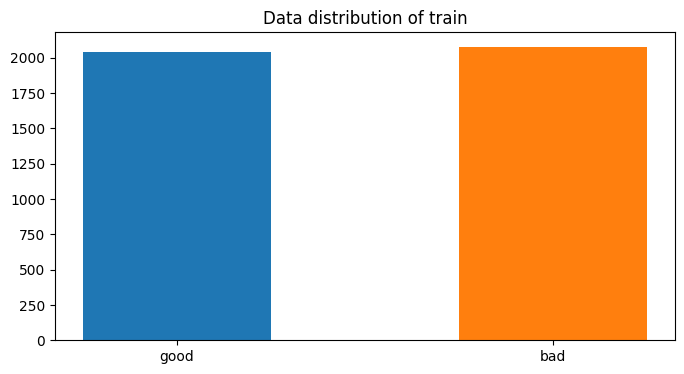

[2037 2076]


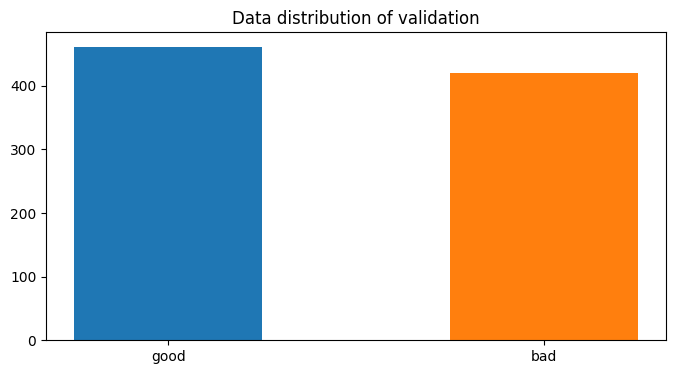

[461 420]


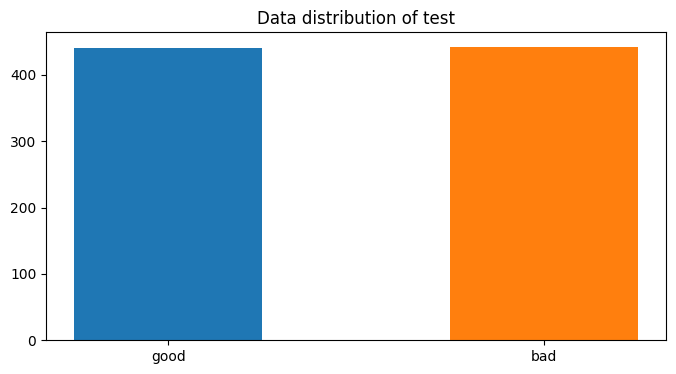

[440 442]


In [ ]:
distribution(train_dataset,"train")
distribution(val_dataset, "validation")
distribution(test_dataset, "test")

###coding a siple neural network
This neural network consists of:

* An input layer that takes flattened data of size 7 * 7 * 512.
* Two hidden layers:
  * The first hidden layer reduces the input size to 512 features and applies ReLU activation.
  * The second hidden layer reduces the size to 128 features and applies ReLU activation.
* An output layer that reduces the size to a single value and applies the sigmoid activation function to produce an output suitable for binary classification.

Images are first flattened into a 1D array of features. The network processes these features through several layers, reducing the dimensionality and applying non-linear transformations (ReLU and sigmoid) to make the final binary classification prediction.
ReLU (Rectified Linear Unit) is used in fc1 and fc2, it introduces non-linearity which helps the model learn and represent more complex decision boundaries.
Sigmoid is used in fc3, it "squashes" the output to a range between 0 and 1, for this reason it's suitable for binary classification.

Is it yes a simple model, but I consider it suitable for my classification problem.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):    # I build a simple feedforward NN classifier
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(7 * 7 * 512, 512)  #fully connected layer that takes an input of size 7 * 7 * 512 and outputs 512 features.
        self.fc2 = nn.Linear(512, 128)          #fully connected layer that takes 512 features as input and outputs 128 features.
        self.fc3 = nn.Linear(128, 1)            #fully connected layer that takes 128 features and outputs a single value, used for binary classification.

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flattens the input tensor except for the batch dimension. If x is of shape (batch_size, 7, 7, 512), it will be reshaped to (batch_size, 7 * 7 * 512).
        x = F.relu(self.fc1(x))    # relu activation to the first layer
        x = F.relu(self.fc2(x))    # relu activation to the second layer
        x = torch.sigmoid(self.fc3(x))  #  sigmoid activation function to the output of the final layer, producing a value between 0 and 1, for binary classification
        return x

model = SimpleClassifier()


As loss function i'll use Binary Cross Entropy Loss, or BCE Loss, is a common loss function used for binary classification tasks where the output of your model is a probability score between 0 and 1.

For a single sample, BCE Loss is defined as:

$\text{BCELoss}(x, y) = -\left[ y \cdot \log(x) + (1 - y) \cdot \log(1 - x) \right]$


where:

* x is the predicted probability (a scalar value between 0 and 1),

* y is the target label (either 0 or 1, indicating the true class).


x is the output of my model passed through a sigmoid function.

Purpose: BCE Loss penalizes the model based on the difference between predicted and actual class labels. It encourages the model to output probabilities close to 1 for positive examples (in my model 1 are anomalies) and close to 0 for negative examples (so good grapes)

##train and validation functions

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Assuming model, train_loader, val_loader are defined

# Define loss function and optimizer
#criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)  # Reshape labels to match outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

###train with metrics definitions, validation looping on combos of different epochs and lr

Epochs: 20, LR: 0.001, Epoch 1/20, Validation Loss: 0.4078, Validation Accuracy: 0.7991, Validation F1 Score: 0.8095, TP: 328, FP: 133, TN: 44, FN: 376, Precision: 0.7387, Recall: 0.8952
Epochs: 20, LR: 0.001, Epoch 2/20, Validation Loss: 0.3451, Validation Accuracy: 0.8593, Validation F1 Score: 0.8551, TP: 391, FP: 70, TN: 54, FN: 366, Precision: 0.8394, Recall: 0.8714
Epochs: 20, LR: 0.001, Epoch 3/20, Validation Loss: 0.3509, Validation Accuracy: 0.8547, Validation F1 Score: 0.8555, TP: 374, FP: 87, TN: 41, FN: 379, Precision: 0.8133, Recall: 0.9024
Epochs: 20, LR: 0.001, Epoch 4/20, Validation Loss: 0.3153, Validation Accuracy: 0.8717, Validation F1 Score: 0.8751, TP: 372, FP: 89, TN: 24, FN: 396, Precision: 0.8165, Recall: 0.9429
Epochs: 20, LR: 0.001, Epoch 5/20, Validation Loss: 0.3227, Validation Accuracy: 0.8842, Validation F1 Score: 0.8886, TP: 372, FP: 89, TN: 13, FN: 407, Precision: 0.8206, Recall: 0.9690
Epochs: 20, LR: 0.001, Epoch 6/20, Validation Loss: 0.4017, Validatio

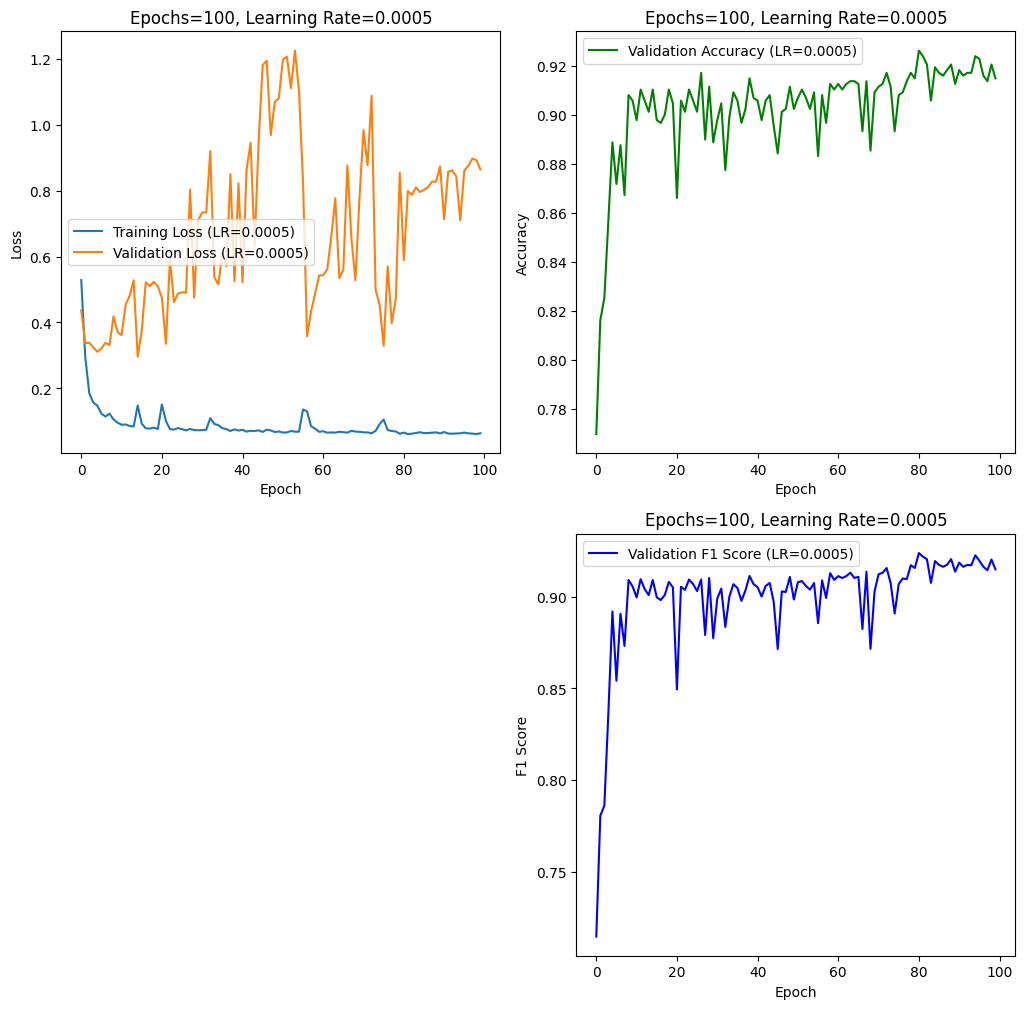

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from itertools import product

# Define ranges for epochs and learning rates to experiment with
epochs_range = [20, 50, 100]  # Example: Test with 20, 50, and 100 epochs
learning_rates = [0.001, 0.0005]  # Example: Test with learning rates 0.001, 0.0005, and 0.01

# Initialize lists to store results
results = {}
best_accuracy = 0.0
best_f1_score = 0.0
best_combination = None

# Iterate over different combinations of epochs and learning rates using itertools.product
for epochs, lr in product(epochs_range, learning_rates):
    # Initialize model, criterion, and optimizer
    model = SimpleClassifier()  # Assuming SimpleClassifier is your model
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store values for this particular combination
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_true_positives = []
    val_false_positives = []
    val_true_negatives = []
    val_false_negatives = []
    val_precisions = []
    val_recalls = []

    # Training loop using train() function
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)

        # Validation loop using validate() function
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Calculate metrics
        with torch.no_grad():
            model.eval()
            all_preds = []
            all_labels = []
            for inputs, labels in val_loader:
                outputs = model(inputs)
                preds = (outputs > 0.5).float()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            # Calculate metrics
            val_f1 = f1_score(all_labels, all_preds)
            val_tp, val_fp, val_tn, val_fn = confusion_matrix(all_labels, all_preds).ravel()

            val_precision = precision_score(all_labels, all_preds)
            val_recall = recall_score(all_labels, all_preds)
            val_accuracy = accuracy_score(all_labels, all_preds)

        val_f1_scores.append(val_f1)
        val_true_positives.append(val_tp)
        val_false_positives.append(val_fp)
        val_true_negatives.append(val_tn)
        val_false_negatives.append(val_fn)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        # Print current combination and metrics
        print(f'Epochs: {epochs}, LR: {lr}, Epoch {epoch+1}/{epochs}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation F1 Score: {val_f1:.4f}, '
              f'TP: {val_tp}, FP: {val_fp}, TN: {val_tn}, FN: {val_fn}, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

    # Determine if this combination is the best found so far based on both accuracy and F1 score
    if val_accuracy > best_accuracy or (val_accuracy == best_accuracy and val_f1 > best_f1_score):
        best_accuracy = val_accuracy
        best_f1_score = val_f1
        best_combination = (epochs, lr, val_loss, val_accuracy, val_f1)
        # Update results with the new best combination
        results = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'val_f1_scores': val_f1_scores,
            'val_true_positives': val_true_positives,
            'val_false_positives': val_false_positives,
            'val_true_negatives': val_true_negatives,
            'val_false_negatives': val_false_negatives,
            'val_precisions': val_precisions,
            'val_recalls': val_recalls
        }

# Print the best combination found
print(f'Best Combination - Epochs: {best_combination[0]}, LR: {best_combination[1]}, Validation Loss: {best_combination[2]:.4f}, Validation Accuracy: {best_combination[3]:.4f}, Validation F1 Score: {best_combination[4]:.4f}')

# Plotting learning curves for the best combination found
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 5)  # Plot at the center
plt.plot(results['train_losses'], label=f'Training Loss (LR={best_combination[1]})')
plt.plot(results['val_losses'], label=f'Validation Loss (LR={best_combination[1]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Epochs={best_combination[0]}, Learning Rate={best_combination[1]}')
plt.legend()

plt.subplot(3, 3, 6)  # Plot at the center right
plt.plot(results['val_accuracies'], label=f'Validation Accuracy (LR={best_combination[1]})', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Epochs={best_combination[0]}, Learning Rate={best_combination[1]}')
plt.legend()

plt.subplot(3, 3, 9)  # Plot at the bottom right
plt.plot(results['val_f1_scores'], label=f'Validation F1 Score (LR={best_combination[1]})', color='blue')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title(f'Epochs={best_combination[0]}, Learning Rate={best_combination[1]}')
plt.legend()

plt.tight_layout()
plt.show()


plot up-sx:
* Training Loss (Blue Line): The training loss decreases steadily and
  reaches a low value close to zero, indicating that the model is learning and fitting the training data well.
  Validation Loss (Orange Line): The validation loss, on the other hand, is quite volatile. It starts relatively high, decreases, but then fluctuates significantly after around 20 epochs
  The divergence between the training and validation loss suggests overfitting. The model performs well on the training data but not consistently on the validation data.<br>
  The high fluctuations in validation loss indicate that the model's performance on unseen could be data unstable.

plot up-dx:
* The validation accuracy starts around 0.78 and steadily increases to
  about 0.91, with some fluctuations but generally showing an upward trend.

plot down-dx:
* The validation F1 score starts below 0.75, increases sharply, and
  stabilizes around 0.90, with some fluctuations.


So generally this model does quite good, it surely is not perfect.

##train with tuned hyperparameters

In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# determined from the previous validation step
best_epochs = 100
best_lr = 0.0005

model = SimpleClassifier()  # Replace with your model class
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# Training loop using the best hyperparameters
for epoch in range(best_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    print(f'Retraining Epoch {epoch+1}/{best_epochs}, Train Loss: {train_loss:.4f}')

'''# Testing the model using the test set (assuming test_loader is defined)
model.eval()
test_loss = 0.0
correct = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        test_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels.view(-1, 1)).sum().item()

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)
test_f1 = f1_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)

# Print test metrics
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, '
      f'F1 Score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')'''


Retraining Epoch 1/100, Train Loss: 0.5410
Retraining Epoch 2/100, Train Loss: 0.3045
Retraining Epoch 3/100, Train Loss: 0.2053
Retraining Epoch 4/100, Train Loss: 0.1707
Retraining Epoch 5/100, Train Loss: 0.1364
Retraining Epoch 6/100, Train Loss: 0.1206
Retraining Epoch 7/100, Train Loss: 0.1221
Retraining Epoch 8/100, Train Loss: 0.1139
Retraining Epoch 9/100, Train Loss: 0.1061
Retraining Epoch 10/100, Train Loss: 0.1037
Retraining Epoch 11/100, Train Loss: 0.1113
Retraining Epoch 12/100, Train Loss: 0.0935
Retraining Epoch 13/100, Train Loss: 0.0804
Retraining Epoch 14/100, Train Loss: 0.0985
Retraining Epoch 15/100, Train Loss: 0.1053
Retraining Epoch 16/100, Train Loss: 0.0982
Retraining Epoch 17/100, Train Loss: 0.0894
Retraining Epoch 18/100, Train Loss: 0.0831
Retraining Epoch 19/100, Train Loss: 0.0898
Retraining Epoch 20/100, Train Loss: 0.1007
Retraining Epoch 21/100, Train Loss: 0.0819
Retraining Epoch 22/100, Train Loss: 0.0765
Retraining Epoch 23/100, Train Loss: 0.07

##test - confusion matrix

Test Loss: 0.7338, Accuracy: 0.9399
Test F1 Score: 0.9423
Test Precision: 0.9078
Test Recall: 0.9796
Test Confusion Matrix: TP: 396, FP: 44, TN: 433, FN: 9


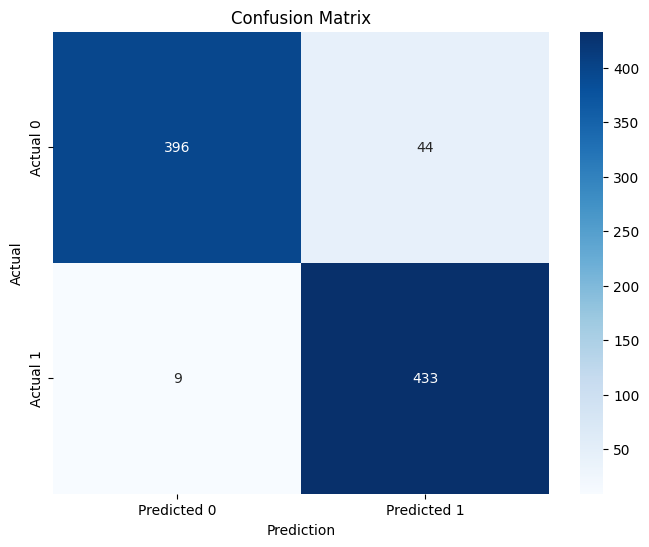

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from itertools import product


model.eval()
test_loss = 0.0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)
test_f1 = f1_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
test_tp, test_fp, test_fn, test_tn = conf_matrix.ravel()

print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Confusion Matrix: TP: {test_tp}, FP: {test_fp}, TN: {test_tn}, FN: {test_fn}')

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Evaluation and confront

As i had analyzed in the [previous plots in the visual analysis section](#Visual-analysis-of-the-feature-from-some-plots)
the model has a clearer, more consistent understanding of good masks, while it shows more uncertainty and variability when dealing with bad masks.<br>
This can be seen in the confusion matrix as well: the number of false negative is way greater than the number of false positive